In [30]:
import numpy as np
import mne
from typing import List, Dict, Union, Optional
from math import ceil

def select_epochs_by_descriptors_with_ar(
    epochs: mne.Epochs,
    raw: mne.io.BaseRaw,
    descriptors: List[str],
    reject_log=None,                         # OPTIONAL: ar.get_reject_log(epochs)
    *,
    fallback_duration_s: float = 1.0,
    min_overlap: float = 0.5,
    case_sensitive: bool = False,
    exclusive: bool = False,
    # ---- AutoReject knobs (used only if reject_log is provided) ----
    allow_interpolated: bool = True,
    max_interp_frac: float = 0.3,
    # ---- Run-length constraints ----
    min_run_epochs: int = 1,
    min_run_seconds: Optional[float] = None,
    # ---- Output selection space ----
    return_epochs: bool = True,
    use_cleaned_space: bool = False,
    epochs_clean: Optional[mne.Epochs] = None
) -> Dict[str, Union[mne.Epochs, np.ndarray]]:
    """
    Select epochs by substring-matching raw.annotations to a list of descriptor strings.
    If reject_log is given (from AutoReject), only 'usable' epochs are kept:
      - drop epochs with any label==1 or marked bad by AR
      - allow label==2 (interpolated) up to max_interp_frac if allow_interpolated=True
    If reject_log is None, all epochs are considered usable.

    If use_cleaned_space=True:
      - With reject_log: map original indices -> epochs_clean via AR's kept mask.
      - Without reject_log: map by matching epochs.events[:,0] to epochs_clean.events[:,0].

    Returns: {descriptor -> Epochs subset (or indices if return_epochs=False)}.
    """
    # ---- derive run-length requirement ----
    ep_len_s = float(epochs.tmax - epochs.tmin)
    if min_run_seconds is not None:
        if ep_len_s <= 0:
            raise ValueError("Epoch duration is zero/invalid.")
        min_run_epochs = max(1, int(ceil(min_run_seconds / ep_len_s)))
    else:
        min_run_epochs = max(1, int(min_run_epochs))

    # ---- AR usable mask (or fallback) ----
    n_epochs = len(epochs)
    if reject_log is None:
        usable = np.ones(n_epochs, dtype=bool)
        bad_epochs = np.zeros(n_epochs, dtype=bool)
        orig_to_clean = None  # may compute via event matching later if needed
    else:
        labels = reject_log.labels  # (n_epochs, n_channels) 0=good,1=bad,2=interp
        bad_epochs = np.asarray(reject_log.bad_epochs, dtype=bool)
        n_ch = labels.shape[1]
        has_bad_unfixed = (labels == 1).any(axis=1)
        interp_counts = (labels == 2).sum(axis=1)
        interp_frac = interp_counts / np.maximum(1, n_ch)
        usable = (~bad_epochs) & (~has_bad_unfixed)
        if allow_interpolated:
            usable &= (interp_frac <= float(max_interp_frac))
        else:
            usable &= (interp_counts == 0)

    # ---- descriptor intervals from annotations ----
    def _norm(s: str) -> str:
        return s if case_sensitive else s.lower()
    q_list = [str(d) if case_sensitive else str(d).lower() for d in descriptors]
    cond_intervals = {d: [] for d in descriptors}

    for ann in raw.annotations:
        ann_desc = _norm(ann["description"])
        onset_s = float(ann["onset"])
        dur_s = float(ann["duration"]) or 0.0
        if dur_s <= 0:
            dur_s = fallback_duration_s
        s = raw.time_as_index(onset_s)[0]
        e = raw.time_as_index(onset_s + dur_s)[0]
        if e <= s:
            e = s + 1
        for q, key in zip(q_list, descriptors):
            if q in ann_desc:
                cond_intervals[key].append((s, e))

    def _merge(iv):
        if not iv:
            return []
        iv = sorted(iv)
        out = [list(iv[0])]
        for s, e in iv[1:]:
            if s <= out[-1][1]:
                out[-1][1] = max(out[-1][1], e)
            else:
                out.append([s, e])
        return [(s, e) for s, e in out]

    for k in cond_intervals:
        cond_intervals[k] = _merge(cond_intervals[k])

    # ---- epoch bounds in raw 0-based sample coords ----
    sf = raw.info["sfreq"]
    first = raw.first_samp
    ev = epochs.events[:, 0]
    ep_st = ev + int(round(epochs.tmin * sf)) - first
    ep_en = ev + int(round(epochs.tmax * sf)) - first  # exclusive end

    # ---- overlap test + usability ----
    cond_indices = {k: [] for k in descriptors}
    for i, (es, ee) in enumerate(zip(ep_st, ep_en)):
        if not usable[i] or ee <= es:
            continue
        need = min_overlap * (ee - es)
        assigned = False
        for name, ivs in cond_intervals.items():
            ok = False
            for s, e in ivs:
                left = max(es, s); right = min(ee, e)
                if right > left and (right - left) >= need:
                    ok = True
                    break
            if ok:
                cond_indices[name].append(i)
                assigned = True
                if exclusive:
                    break

    # ---- enforce minimum run length ----
    def _filter_runs(idxs: List[int], min_run_n: int) -> List[int]:
        if not idxs:
            return []
        idxs = np.array(sorted(set(idxs)), dtype=int)
        cuts = np.where(np.diff(idxs) != 1)[0] + 1
        starts = np.r_[0, cuts]
        ends = np.r_[cuts, len(idxs)]
        keep = []
        for s, e in zip(starts, ends):
            run = idxs[s:e]
            if len(run) >= min_run_n:
                keep.extend(run.tolist())
        return keep

    for k in cond_indices:
        cond_indices[k] = _filter_runs(cond_indices[k], min_run_epochs)

    # ---- map to cleaned space if requested ----
    if use_cleaned_space:
        if epochs_clean is None:
            raise ValueError("use_cleaned_space=True requires epochs_clean.")
        if reject_log is not None:
            kept_idx = np.flatnonzero(~bad_epochs)  # original -> cleaned order
            orig_to_clean = {orig: i for i, orig in enumerate(kept_idx)}
        else:
            # Build mapping by matching event sample codes
            ev_clean = epochs_clean.events[:, 0]
            orig_to_clean = {int(samp): i for i, samp in enumerate(ev_clean)}
        mapped = {}
        for k, idxs in cond_indices.items():
            if reject_log is not None:
                mapped[k] = [orig_to_clean[i] for i in idxs if i in orig_to_clean]
            else:
                # translate via event sample number
                mapped[k] = []
                for i in idxs:
                    samp = int(ev[i])
                    if samp in orig_to_clean:
                        mapped[k].append(orig_to_clean[samp])
        cond_indices = mapped

    # ---- return Epochs or indices ----
    if return_epochs:
        if use_cleaned_space:
            return {k: epochs_clean[cond_indices[k]] for k in descriptors}
        else:
            return {k: epochs[cond_indices[k]] for k in descriptors}
    else:
        return {k: np.array(cond_indices[k], dtype=int) for k in descriptors}


In [7]:
import numpy as np
from mushroom_hyperscanning.data import load_eeg
import mne

SUBJECT = "01"
CEREMONY = "ceremony2"
BIDS_ROOT = "../data/003_sanitization"

raw = load_eeg(SUBJECT, CEREMONY, root=BIDS_ROOT, preload=True)
#raw.crop(tmax=60 * 20)  # use 20 minutes of data to test

# Apply a band-pass filter to EEG (e.g. 0.3–45 Hz)
raw.filter(l_freq=1, h_freq=60, picks="eeg", phase="zero")

# Optionally also remove line noise (60 Hz harmonics for Québec/Canada)
raw.notch_filter(freqs=[60], picks="eeg", phase="zero")

events = mne.make_fixed_length_events(raw, duration=2.0)  
epochs = mne.Epochs(raw, events, tmin=0, tmax=2.0, baseline=None, preload=True)  


var1 = 'control'
var2 = 'limpia'
# Descriptors to look for inside annotation descriptions (substring match)
desc_list = [var1, var2]

selected = select_epochs_by_descriptors_with_ar(
    epochs=epochs,
    raw=raw,
    reject_log=None,                         # OPTIONAL: ar.get_reject_log(epochs)
    descriptors=desc_list,
    fallback_duration_s=15,   # if some annots have 0 duration
    min_overlap=0.5,           # ≥50% of epoch must lie inside the interval
    case_sensitive=False,
    exclusive=False,           # allow an epoch to belong to multiple labels
    return_epochs=True,
    min_run_seconds=3.0        # keep only runs ≥ 3 seconds (with 1-s epochs: ≥3 in a row)
)

epochs_1  = selected[var1]
epochs_2  = selected[var2]


Extracting EDF parameters from c:\Users\skite\Documents\Github\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony2\eeg\sub-01_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 991 samples (3.303 s)



C:\Users\skite\Documents\Github\mushroom_hyperscanning\mushroom_hyperscanning\data.py:39: RuntimeWarning: The unit for channel(s) CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.7s finished


Not setting metadata
10165 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10165 events and 601 original time points ...
1 bad epochs dropped


In [8]:
epochs_2

Number of events,196
Events,1: 196
Time range,0.000 – 2.000 s
Baseline,off


Effective window size : 1.003 (s)
Effective window size : 1.003 (s)


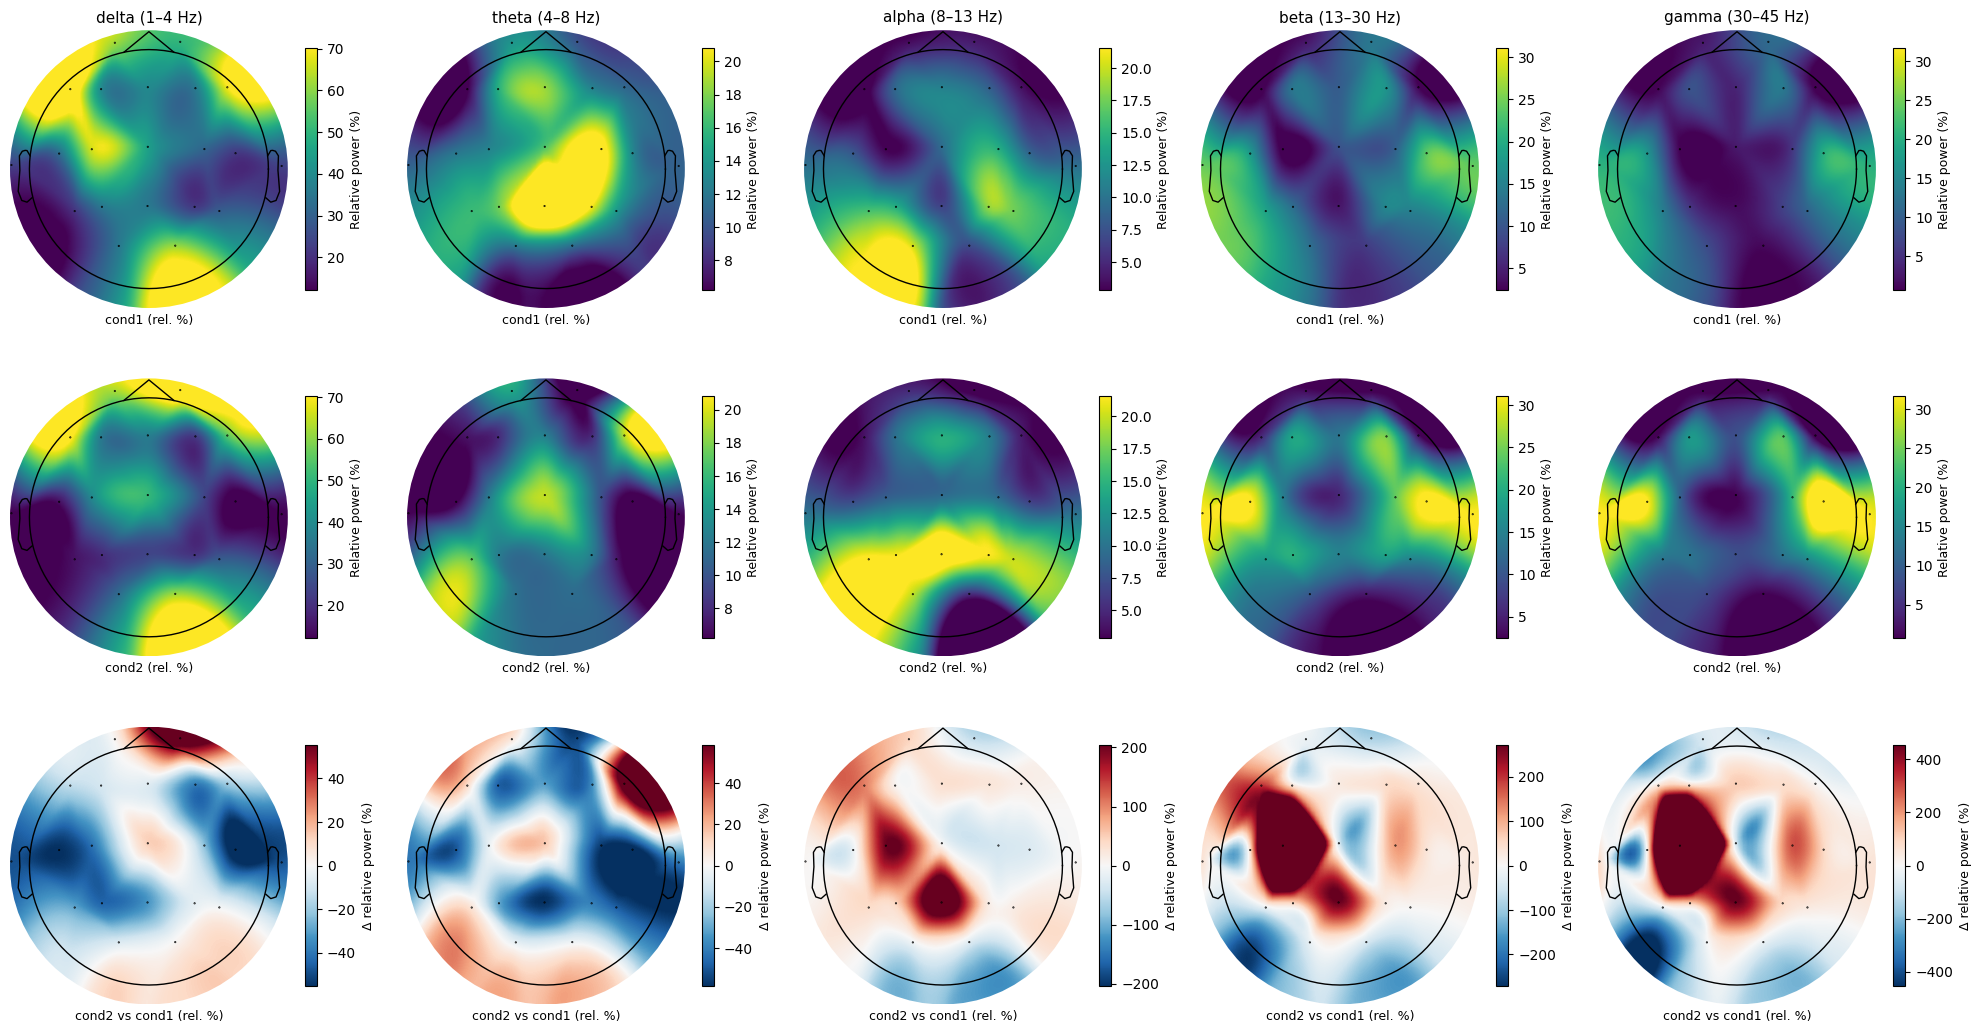

In [54]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Inputs: epochs_1 (control) and epochs_2 (song) must already exist
# ---------------------------------------------------------------------

# Config
FMIN_ALL, FMAX_ALL = 1., 45.
N_JOBS = 1                 # set >1 if you want
BANDS = {
    'delta (1–4 Hz)':  (1., 4.),
    'theta (4–8 Hz)':  (4., 8.),
    'alpha (8–13 Hz)': (8., 13.),
    'beta (13–30 Hz)': (13., 30.),
    'gamma (30–45 Hz)': (30., 45.),
}

# Ensure a montage (does nothing if already set)
montage = mne.channels.make_standard_montage('standard_1020')
for ep in (epochs_1, epochs_2):
    try:
        ep.set_montage(montage, match_case=False)
    except Exception:
        pass

# ---------------------------------------------------------------------
# Make both Epochs have the same EEG channels in the same order
# ---------------------------------------------------------------------
ep1_eeg = epochs_1.copy().pick(picks='eeg')
ep2_eeg = epochs_2.copy().pick(picks='eeg')

common_eeg = [ch for ch in ep1_eeg.ch_names if ch in set(ep2_eeg.ch_names)]
if not common_eeg:
    raise ValueError("No common EEG channels between the two Epochs.")
epochs_1 = ep1_eeg.copy().pick(picks=common_eeg)
epochs_2 = ep2_eeg.copy().pick(picks=common_eeg)

conds = {'cond1': epochs_1, 'cond2': epochs_2}
cond_order = list(conds.keys())  # contrast will be cond_order[1] - cond_order[0] (relative %)

# ---------------------------------------------------------------------
# PSD (Welch) once per condition on 1–45 Hz, in µV^2/Hz
# ---------------------------------------------------------------------
psd_data = {}  # cond -> (psds_uV2_perHz, freqs, info)
for name, ep in conds.items():
    psd = ep.compute_psd(
        method='welch',
        fmin=FMIN_ALL, fmax=FMAX_ALL,
        n_overlap=0, n_jobs=N_JOBS
    )
    P, f = psd.get_data(return_freqs=True)       # (n_epochs, n_ch, n_f), (n_f,)
    P = P * 1e12                                 # V^2/Hz -> µV^2/Hz
    psd_data[name] = (P, f, ep.info)

# ---------------------------------------------------------------------
# Relative band power (band / total 1–45 Hz) in percent
# ---------------------------------------------------------------------
rel_maps = {b: {} for b in BANDS}   # band -> cond -> (n_ch,)
rel_vlims = {}                      # band -> (vmin, vmax)

for band_name, (fmin, fmax) in BANDS.items():
    all_vals = []
    for name, (P, f, info) in psd_data.items():
        fi = np.where((f >= fmin) & (f <= fmax))[0]
        if fi.size < 2:
            raise RuntimeError(f"Insufficient frequency bins for {band_name}")

        band_power = np.trapz(P[:, :, fi], f[fi], axis=2).mean(axis=0)     # µV^2, per ch
        total_power = np.trapz(P, f, axis=2).mean(axis=0) + np.finfo(float).eps
        rel_pct = 100.0 * (band_power / total_power)                       # %
        rel_maps[band_name][name] = rel_pct
        all_vals.append(rel_pct)

    all_vals = np.concatenate(all_vals)
    vmin = float(np.percentile(all_vals, 5))
    vmax = float(np.percentile(all_vals, 95))
    if vmin == vmax:
        vmax = vmin + 1e-6
    rel_vlims[band_name] = (vmin, vmax)

# ---------------------------------------------------------------------
# Contrast (relative change): (cond2 - cond1) / cond1 * 100 (%)
# ---------------------------------------------------------------------
contrast_maps = {}   # band -> (n_ch,)
for band_name in BANDS.keys():
    b = rel_maps[band_name]
    if len(cond_order) >= 2:
        baseline = b[cond_order[0]]
        contrast_maps[band_name] = 100.0 * (
            (b[cond_order[1]] - baseline) / (baseline + np.finfo(float).eps)
        )
    else:
        contrast_maps[band_name] = np.zeros_like(next(iter(b.values())))

# Symmetric limits per band for contrast (robust)
contrast_vlims = {}
for band_name, vals in contrast_maps.items():
    a5, a95 = np.percentile(vals, [5, 95])
    m = float(max(abs(a5), abs(a95)))
    contrast_vlims[band_name] = (-m, m) if m > 0 else (-1e-6, 1e-6)

# ---------------------------------------------------------------------
# Plot: rows = [control (rel %), song (rel %), contrast (relative % change)]
# ---------------------------------------------------------------------
n_rows = 3 if len(conds) >= 2 else len(conds)
fig, axes = plt.subplots(n_rows, len(BANDS),
                         figsize=(4 * len(BANDS), 3.6 * n_rows),
                         squeeze=False)

# Condition rows (relative %)
for r, cname in enumerate(cond_order):
    info = psd_data[cname][2]
    for c, (band_name, _) in enumerate(BANDS.items()):
        data = rel_maps[band_name][cname]
        vmin, vmax = rel_vlims[band_name]
        ax = axes[r, c]
        im, _ = mne.viz.plot_topomap(
            data, info, axes=ax, show=False, contours=0,
            cmap='viridis', vlim=(vmin, vmax)
        )
        if r == 0:
            ax.set_title(band_name, fontsize=11)
        ax.set_xlabel(f"{cname} (rel. %)", fontsize=9)
        cb = plt.colorbar(im, ax=ax, shrink=0.7)
        cb.set_label('Relative power (%)', rotation=90, fontsize=9)

# Contrast row (relative % change)
if len(conds) >= 2:
    info = psd_data[cond_order[0]][2]  # same channel layout/order
    r = 2
    for c, (band_name, _) in enumerate(BANDS.items()):
        data = contrast_maps[band_name]
        vmin, vmax = contrast_vlims[band_name]
        ax = axes[r, c]
        im, _ = mne.viz.plot_topomap(
            data, info, axes=ax, show=False, contours=0,
            cmap='RdBu_r', vlim=(vmin, vmax)
        )
        ax.set_xlabel(f"{cond_order[1]} vs {cond_order[0]} (rel. %)", fontsize=9)
        cb = plt.colorbar(im, ax=ax, shrink=0.7)
        cb.set_label('Δ relative power (%)', rotation=90, fontsize=9)

plt.tight_layout()
plt.show()


## Connectivity

In [48]:
import mne
from mushroom_hyperscanning.data import load_eeg

BIDS_ROOT = "../data/003_sanitization"
CEREMONY = "ceremony2"
SUBJECTS = ["01", "04"]

conditions = ["control", "connection-sub01"]

def get_epochs(subject, condition):
    raw = load_eeg(subject, CEREMONY, root=BIDS_ROOT, preload=True)
    events = mne.make_fixed_length_events(raw, duration=5.0)  
    epochs = mne.Epochs(raw, events, tmin=0, tmax=5.0, baseline=None, preload=True)  
    
    selected = select_epochs_by_descriptors_with_ar(
        epochs=epochs,
        raw=raw,
        reject_log=None,                      
        descriptors=[condition],
        fallback_duration_s=15,
        min_overlap=0.5,
        case_sensitive=False,
        exclusive=False,
        return_epochs=True,
        min_run_seconds=3.0
    )
    return selected[condition]

# subject 1
epo1_cond1 = get_epochs("01", "control")
epo1_cond2 = get_epochs("01", "connection")

# subject 4
epo2_cond1 = get_epochs("04", "control")
epo2_cond2 = get_epochs("04", "connection")


Extracting EDF parameters from c:\Users\skite\Documents\Github\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony2\eeg\sub-01_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Not setting metadata
4066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4066 events and 1501 original time points ...


C:\Users\skite\Documents\Github\mushroom_hyperscanning\mushroom_hyperscanning\data.py:39: RuntimeWarning: The unit for channel(s) CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


1 bad epochs dropped
Extracting EDF parameters from c:\Users\skite\Documents\Github\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony2\eeg\sub-01_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Not setting metadata
4066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4066 events and 1501 original time points ...


C:\Users\skite\Documents\Github\mushroom_hyperscanning\mushroom_hyperscanning\data.py:39: RuntimeWarning: The unit for channel(s) CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


1 bad epochs dropped
Extracting EDF parameters from c:\Users\skite\Documents\Github\mushroom_hyperscanning\data\003_sanitization\sub-04\ses-ceremony2\eeg\sub-04_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Not setting metadata
4066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4066 events and 1501 original time points ...


C:\Users\skite\Documents\Github\mushroom_hyperscanning\mushroom_hyperscanning\data.py:39: RuntimeWarning: The unit for channel(s) Ax, Ay, Az, CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


1 bad epochs dropped
Extracting EDF parameters from c:\Users\skite\Documents\Github\mushroom_hyperscanning\data\003_sanitization\sub-04\ses-ceremony2\eeg\sub-04_ses-ceremony2_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6098999  =      0.000 ... 20329.997 secs...
Not setting metadata
4066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4066 events and 1501 original time points ...


C:\Users\skite\Documents\Github\mushroom_hyperscanning\mushroom_hyperscanning\data.py:39: RuntimeWarning: The unit for channel(s) Ax, Ay, Az, CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


1 bad epochs dropped


In [49]:
  
def match_epochs_by_index(epo1_cond1, epo1_cond2, epo2_cond1, epo2_cond2):  
    """  
    Find common epoch indices across all conditions and participants  
    """  
    # Get event IDs for each condition/participant  
    events1_cond1 = set(epo1_cond1.events[:, 2])  
    events1_cond2 = set(epo1_cond2.events[:, 2])   
    events2_cond1 = set(epo2_cond1.events[:, 2])  
    events2_cond2 = set(epo2_cond2.events[:, 2])  
      
    # Find common indices across all  
    common_indices = events1_cond1.intersection(events1_cond2, events2_cond1, events2_cond2)  
      
    return list(common_indices)  
  
# Step 2: Extract epochs with matching indices  
common_indices = match_epochs_by_index(epo1_cond1, epo1_cond2, epo2_cond1, epo2_cond2)  
  
# Select epochs with matching indices for each condition  
epo1_cond1_matched = epo1_cond1[np.isin(epo1_cond1.events[:, 2], common_indices)]  
epo1_cond2_matched = epo1_cond2[np.isin(epo1_cond2.events[:, 2], common_indices)]  
epo2_cond1_matched = epo2_cond1[np.isin(epo2_cond1.events[:, 2], common_indices)]  
epo2_cond2_matched = epo2_cond2[np.isin(epo2_cond2.events[:, 2], common_indices)]  
  
# Step 3: Equalize epoch counts (as shown in tutorial)  
mne.epochs.equalize_epoch_counts([epo1_cond1_matched, epo2_cond1_matched])  
mne.epochs.equalize_epoch_counts([epo1_cond2_matched, epo2_cond2_matched])  


Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 
Dropped 0 epochs: 


In [50]:
epo2_cond2_matched

Number of events,148
Events,1: 148
Time range,0.000 – 5.000 s
Baseline,off


In [51]:
import numpy as np
import mne
from hypyp import analyses, viz, stats

# --- 1) Helpers ---------------------------------------------------------------

def align_epochs_for_hypyp(epo_a: mne.Epochs, epo_b: mne.Epochs, drop_bads=True):
    """Make two Epochs objects shape-compatible: same channels (order), same n_epochs."""
    # 1) keep only common EEG channels and enforce identical ordering
    common = [ch for ch in epo_a.ch_names if ch in epo_b.ch_names]
    if not common:
        raise RuntimeError("No common channels between the two Epochs.")
    a = epo_a.copy().pick_channels(common, ordered=True)
    b = epo_b.copy().pick_channels(common, ordered=True)

    # 2) drop union of bads (optional)
    if drop_bads:
        bads = list(set(a.info.get('bads', [])) | set(b.info.get('bads', [])))
        if bads:
            a.drop_channels(bads, on_missing='ignore')
            b.drop_channels(bads, on_missing='ignore')

    # 3) sanity: same sfreq & n_times
    if a.info['sfreq'] != b.info['sfreq']:
        raise RuntimeError(f"Different sfreq: {a.info['sfreq']} vs {b.info['sfreq']}")
    if a.get_data().shape[-1] != b.get_data().shape[-1]:
        raise RuntimeError("Different n_times between subjects. Check epoching/cropping.")

    # 4) equalize epoch counts IN PLACE
    mne.epochs.equalize_epoch_counts([a, b], method='truncate')
    return a, b

def compute_interbrain_connectivity(epo_a, epo_b, freq_bands, mode='ccorr', epochs_average=True):
    """
    Returns connectivity per band with shape:
      result: (n_bands, 2*n_ch, 2*n_ch)
      inter-brain slice for band bi: result[bi, 0:n_ch, n_ch:2*n_ch]
    """
    # Ensure aligned
    a, b = align_epochs_for_hypyp(epo_a, epo_b, drop_bads=True)
    sfreq = a.info['sfreq']
    n_ch = len(a.ch_names)

    # HyPyP expects data shaped (2, n_epochs, n_channels, n_times)
    data_inter = [a.get_data(), b.get_data()]  # list is fine

    # High-level wrapper does TF + connectivity
    con = analyses.pair_connectivity(
        data_inter, sampling_rate=sfreq, frequencies=freq_bands,
        mode=mode, epochs_average=epochs_average
    )
    # con shape: (n_freqs_or_bands, 2*n_ch, 2*n_ch)
    # Extract only inter-brain block for each band
    C_inter = con[:, 0:n_ch, n_ch:2*n_ch]
    return C_inter, a, b  # return aligned epochs too for viz


def compute_interbrain_connectivity_directional(epo_a, epo_b, freq_bands, measure='pdc'):  
    """  
    Compute directional inter-brain connectivity using MVAR modeling  
    """  
    # Ensure aligned  
    a, b = align_epochs_for_hypyp(epo_a, epo_b, drop_bads=True)  
    sfreq = a.info['sfreq']  
    n_ch = len(a.ch_names)  
  
    # Prepare data for MVAR analysis  
    data_inter = [a.get_data(), b.get_data()]  
      
    # Compute analytic signal in frequency bands  
    complex_signal = analyses.compute_freq_bands(  
        data_inter, sfreq, freq_bands,  
        filter_length='auto',  
        l_trans_bandwidth='auto',  
        h_trans_bandwidth='auto' 
    )  
      
    # MVAR parameters  
    mvar_params = {  
        'mvar_order': 5,  
        'fitting_method': 'default',   
        'delta': 0 
    }  
      
    # ICA parameters  
    ica_params = {  
        'method': 'infomax_extended',  
        'random_state': 42  
    }  
      
    # Connectivity measure parameters  
    measure_params = {  
        'name': measure,  # 'pdc' or 'dtf'  
        'n_fft': 512  
    }  
      
    # Compute directional connectivity  
    conn = analyses.compute_conn_mvar(  
        complex_signal,   
        mvar_params,   
        ica_params,   
        measure_params,  
        check_stability=True  
    )  
      
    return conn, a, b

# --- 2) Prepare your matched epochs (use your own matched objects) ------------
# You already built:
#   epo1_cond1_matched, epo1_cond2_matched, epo2_cond1_matched, epo2_cond2_matched
# IMPORTANT: your earlier match-by-event-id doesn’t work with fixed-length events
# (all event IDs are identical). We rely on equalize_epoch_counts inside aligner.





In [52]:

freq_bands = {'Alpha-Low': [7.5, 11], 'Alpha-High': [11.5, 13], 'Theta': [4, 7.5], 'Delta': [1, 4], 'Low-Beta': [13, 20], 'High-Beta': [20, 30], 'Gamma1': [30, 45]}
mode = 'imaginary_coh'
# Condition 1 (e.g., control)
C_cond1, epo1_c1_aligned, epo2_c1_aligned = compute_interbrain_connectivity(
    epo1_cond1_matched, epo2_cond1_matched, freq_bands, mode=mode, epochs_average=True
)
# Condition 2 (e.g., limpia)
C_cond2, epo1_c2_aligned, epo2_c2_aligned = compute_interbrain_connectivity(
    epo1_cond2_matched, epo2_cond2_matched, freq_bands, mode=mode, epochs_average=True
)



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dropped 0 epochs: 
Dropped 0 epochs: 


C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_inter = [a.get_data(), b.get_data()]  # list is fine
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_int

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dropped 0 epochs: 
Dropped 0 epochs: 


C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_inter = [a.get_data(), b.get_data()]  # list is fine
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_int

In [22]:
freq_bands = {'Alpha-Low': [7.5, 11], 'Alpha-High': [11.5, 13], 'Theta': [4, 7.5], 'Delta': [1, 4], 'Low-Beta': [13, 20], 'High-Beta': [20, 30], 'Gamma1': [30, 45]}
# Use directional connectivity instead  
measure = 'pdc'  # or 'dtf'  
  
# Condition 1 (e.g., control)  
C_cond1, epo1_c1_aligned, epo2_c1_aligned = compute_interbrain_connectivity_directional(  
    epo1_cond1_matched, epo2_cond1_matched, freq_bands, measure=measure  
)  
  
# Condition 2 (e.g., limpia)  
C_cond2, epo1_c2_aligned, epo2_c2_aligned = compute_interbrain_connectivity_directional(  
    epo1_cond2_matched, epo2_cond2_matched, freq_bands, measure=measure  
)  

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dropped 0 epochs: 
Dropped 0 epochs: 


C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  if a.get_data().shape[-1] != b.get_data().shape[-1]:
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:68: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_inter = [a.get_data(), b.get_data()]
C:\Users\skite\AppData\Local\Temp\ipykernel_37632\1584199862.py:68: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_inter = [a.get_data

MVAR model is not stable: number of time samples may be too small!


At least 10580 samples are required for fitting MVAR model.




KeyboardInterrupt: Interrupted by user

In [25]:
print(f"C1 range: {np.min(C1):.3f} to {np.max(C1):.3f}")  
print(f"C1 mean: {np.mean(C1):.3f}, std: {np.std(C1):.3f}")

NameError: name 'C1' is not defined

Condition 1 – 2D:


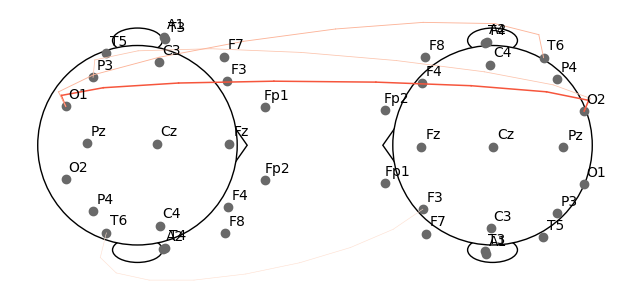

Condition 1 – 3D:


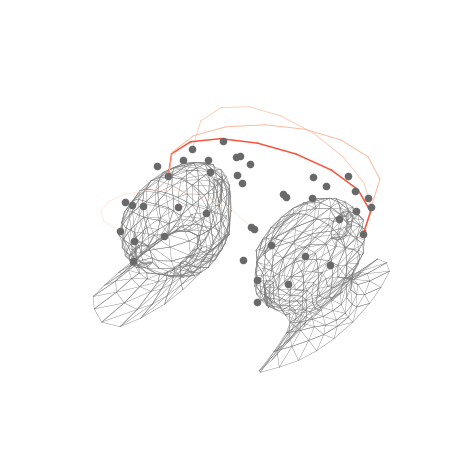

Condition 2 – 2D:


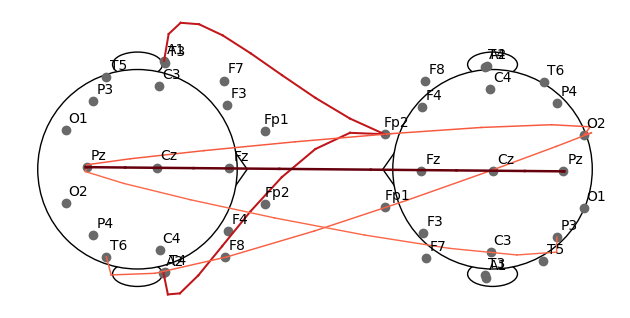

Condition 2 – 3D:


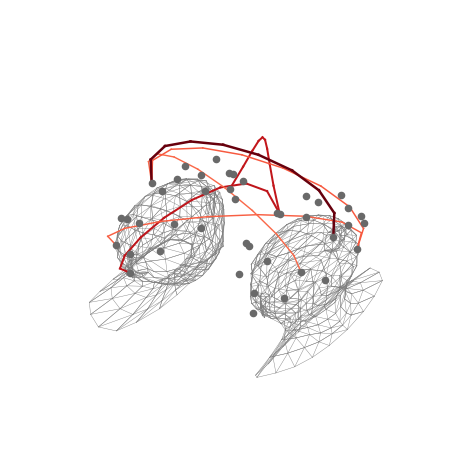

In [61]:
# ---- Select a band for visualization ----

# C_condX has shape (2 bands, n_ch, n_ch). Pick a band for visualization:
band_names = list(freq_bands.keys())
band_idx = band_names.index('Low-Beta')  # or 'Alpha-High'
C1 = C_cond1[band_idx]
C2 = C_cond2[band_idx]

# --- 3) Visualize -------------------------------------------------------------
# Use the *aligned* epochs returned above
thresh = 'auto'
print("Condition 1 – 2D:")
viz.viz_2D_topomap_inter(epo1_c1_aligned, epo2_c1_aligned, C1, threshold=thresh, steps=10, lab=True)
print("Condition 1 – 3D:")
viz.viz_3D_inter(epo1_c1_aligned, epo2_c1_aligned, C1, threshold=thresh, steps=10, lab=False)

print("Condition 2 – 2D:")
viz.viz_2D_topomap_inter(epo1_c2_aligned, epo2_c2_aligned, C2, threshold=thresh, steps=10, lab=True)
print("Condition 2 – 3D:")
viz.viz_3D_inter(epo1_c2_aligned, epo2_c2_aligned, C2, threshold=thresh, steps=10, lab=False)

# --- 4) (Optional) cluster stats scaffold ------------------------------------
# Cluster stats need multiple observations (e.g., multiple dyads or sessions).
# With a single dyad, permutation tests are not meaningful.
# The snippet below guards against that and shows the expected shapes.

do_stats = False  # set True only if you have >= ~10 observations per condition

if do_stats:
    # Build channel–frequency connectivity (alpha-low only here)
    # Flatten n_ch x n_ch to vector per observation if you keep epochs_average=False upstream.
    # With epochs_average=True, you already have one matrix per dyad/condition.
    # Example uses spatial+frequency connectivity helper:
    from hypyp.stats import con_matrix, metaconn_matrix_2brains, indices_connectivity_interbrain

    # Create a merged Epochs to get inter-brain indices for metaconn (any aligned pair works)
    merged = mne.concatenate_epochs([epo1_c1_aligned.copy(), epo2_c1_aligned.copy()])
    inter_pairs = analyses.indices_connectivity_interbrain(merged)

    alpha_freqs = np.arange(8, 13)
    conn = stats.con_matrix(epo1_c1_aligned, freqs_mean=alpha_freqs)
    meta = stats.metaconn_matrix_2brains(inter_pairs, conn.ch_con, freqs_mean=alpha_freqs)

    # data_for_stats must be [array(shape=(n_obs, n_features)), array(...)]
    # You would stack *many* dyads/session entries here.
    # stats.statscondCluster(data, freqs_mean=alpha_freqs, ch_con_freq=meta.metaconn_freq,
    #                        tail=0, n_permutations=5000, alpha=0.05)
    pass

## Directional

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Dropped 0 epochs: 
Dropped 0 epochs: 


KeyboardInterrupt: 